In [1]:
import torch as th

from torchvision import transforms

In [2]:
from src.dataloader import customDataloader
from src.utils import train_loop, test_model, init_weights
from src.plots import plot_statistics
from models.model import Model

# Exercise 1

In [9]:
train_loader, validation_loader, test_loader = customDataloader(transform=None, batch_size=32, shuffle=True)

In [4]:
model = Model()
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), momentum=0.5)

In [5]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 47%|▍| 47/100 [00:48<00:55,  1.04s/it, Train Loss=0.447, Test Loss=5.17, Train Acc=0.862, T

Stopped early, epoch: 47


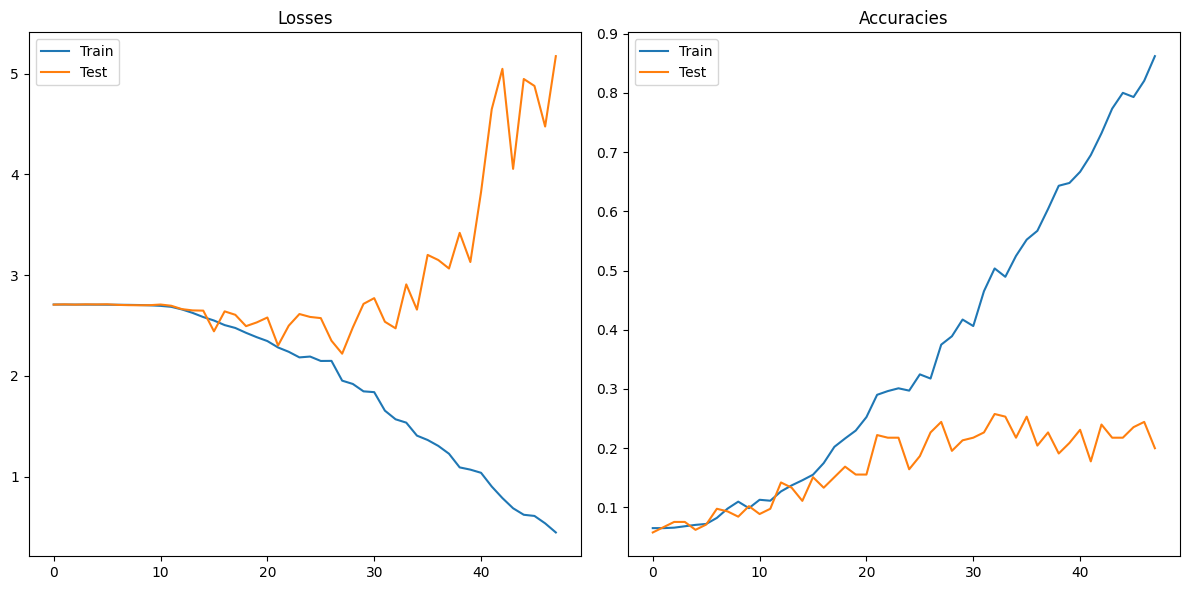

In [6]:
plot_statistics(statistics)

Test Loss: 5.423304080963135
Test Accuracy: 0.2204355150461197


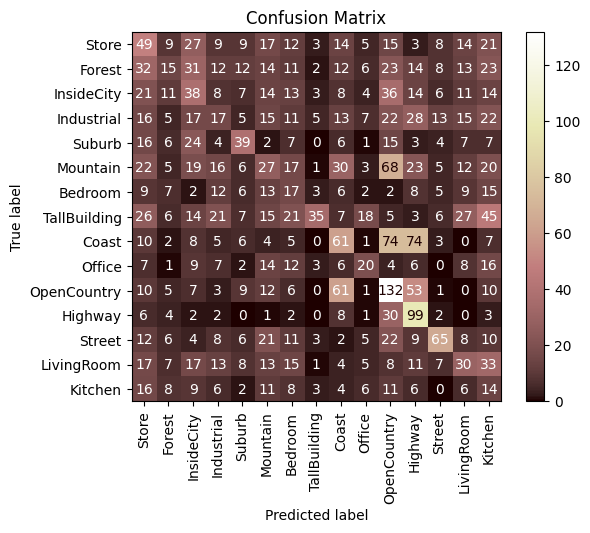

In [7]:
test_model(model, test_loader, criterion)

# Exercise 2

In [8]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5)
])

In [9]:
train_loader, validation_loader, test_loader = customDataloader(transform=transform, batch_size=32, shuffle=True)

## Horizontal Flip

In [37]:
model = Model()
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), momentum=0.5)

In [38]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 69%|▋| 69/100 [01:20<00:36,  1.16s/it, Train Loss=0.572, Test Loss=2.83, Train Acc=0.813, T

Stopped early, epoch: 69


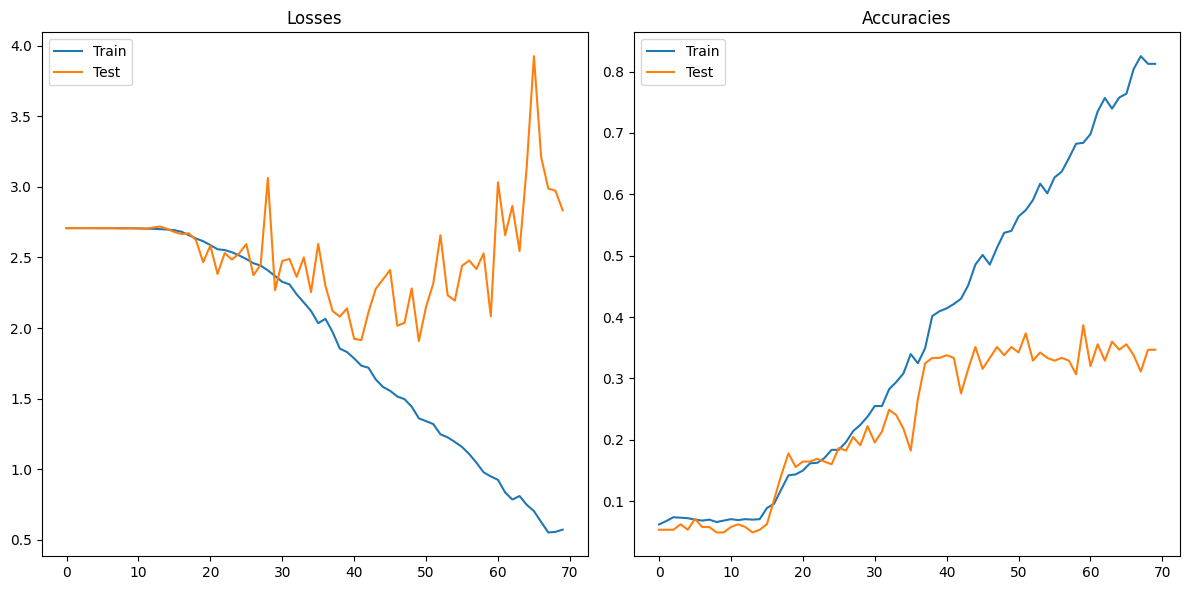

In [39]:
plot_statistics(statistics)

Test Loss: 3.488353757148093
Test Accuracy: 0.33936348408710215


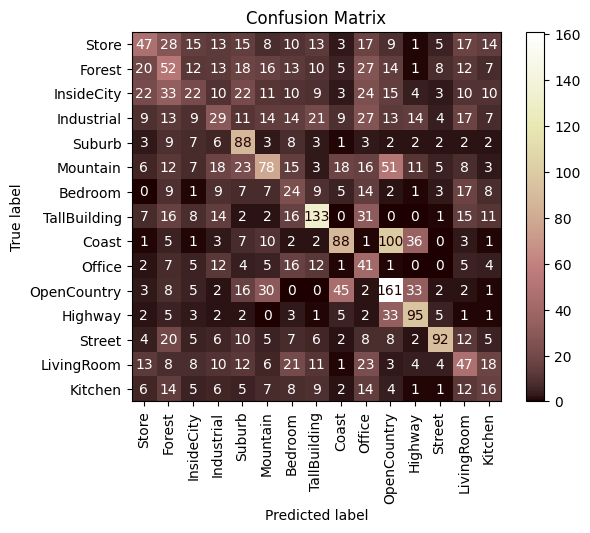

In [40]:
test_model(model, test_loader, criterion)

## Batch Normalization
Kernel Size = 3


In [5]:
model = Model(normalization=True)
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), momentum=0.5)

In [6]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 58%|▌| 58/100 [01:08<00:49,  1.18s/it, Train Loss=0.377, Test Loss=1.48, Train Acc=0.934, T

Stopped early, epoch: 58


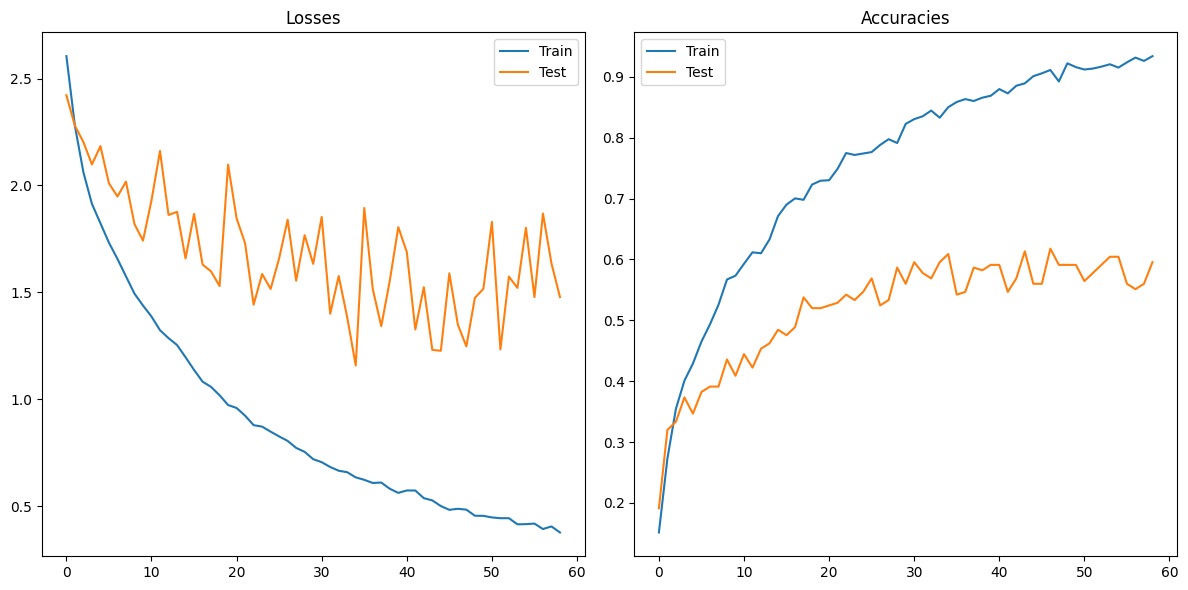

In [7]:
plot_statistics(statistics)

Test Loss: 1.1971250195452507
Test Accuracy: 0.5949748743718593


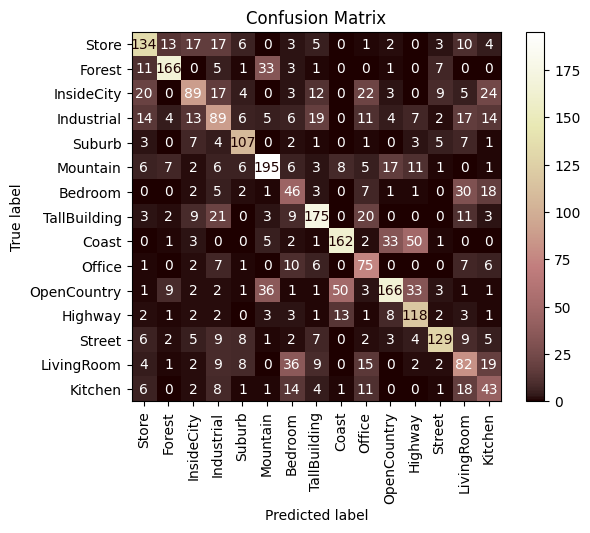

In [8]:
test_model(model, test_loader, criterion)

## Batch Normalization 
Kernel Size = 5

In [5]:
model = Model(kernel_size=5, normalization=True)
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), momentum=0.5)

In [6]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 70%|▋| 70/100 [01:49<00:47,  1.57s/it, Train Loss=0.454, Test Loss=1.66, Train Acc=0.909, T

Stopped early, epoch: 70


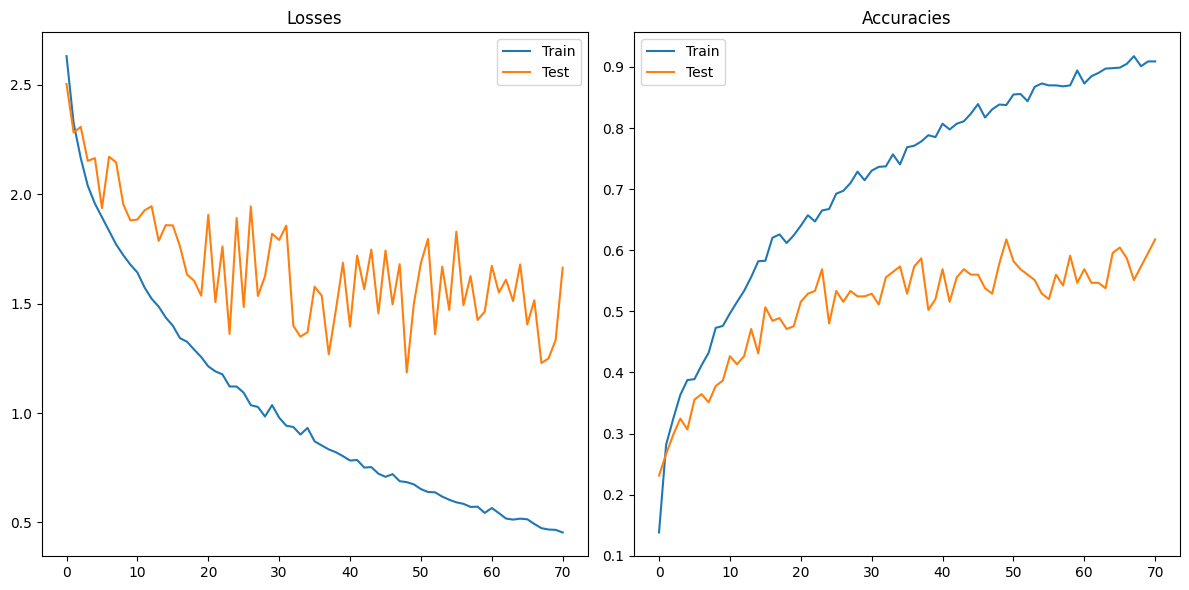

In [7]:
plot_statistics(statistics)

Test Loss: 1.3425306417840592
Test Accuracy: 0.5567839195979899


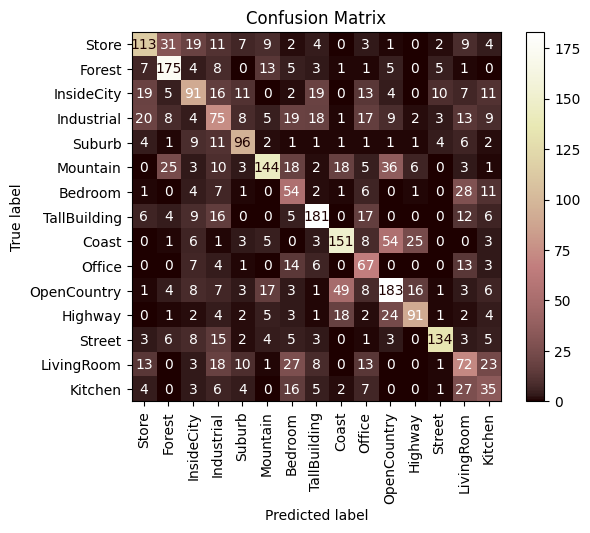

In [8]:
test_model(model, test_loader, criterion)

## Batch Normalization 
Kernel Size = 7

In [9]:
model = Model(kernel_size=7, normalization=True)
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), momentum=0.5)

In [10]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 85%|▊| 85/100 [02:09<00:22,  1.52s/it, Train Loss=0.574, Test Loss=1.58, Train Acc=0.867, T

Stopped early, epoch: 85


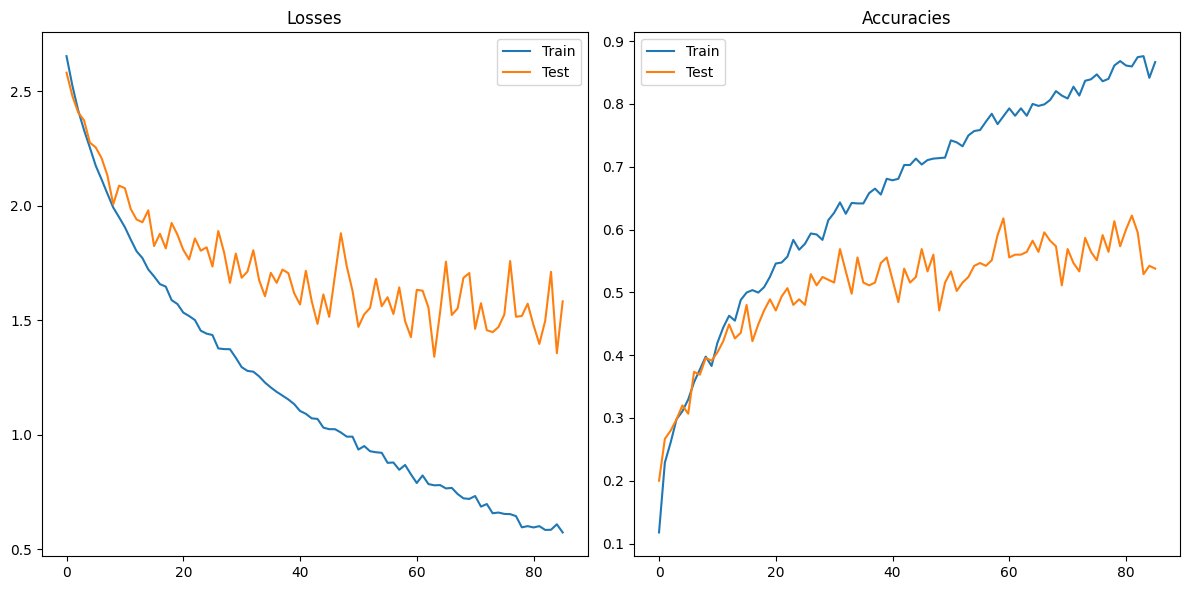

In [11]:
plot_statistics(statistics)

Test Loss: 1.3599562270844237
Test Accuracy: 0.5490787269681742


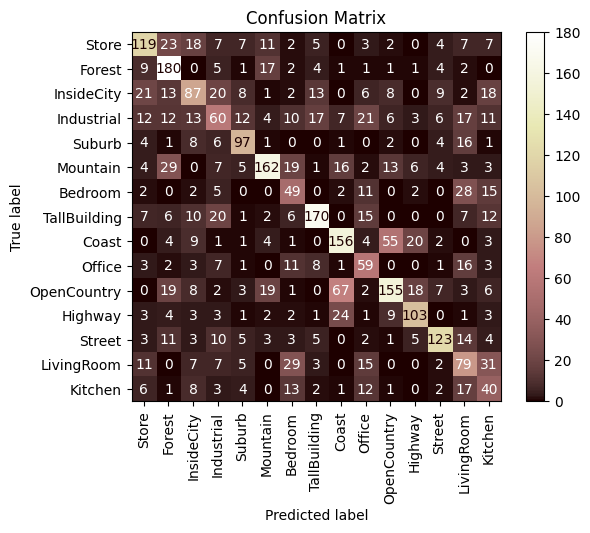

In [12]:
test_model(model, test_loader, criterion)

## Batch Normalization + Adam
Kernel Size = 3


In [14]:
model = Model(kernel_size=3, normalization=True)
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters())

In [15]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 29%|▎| 29/100 [00:48<01:57,  1.66s/it, Train Loss=0.0241, Test Loss=2.34, Train Acc=0.999, 

Stopped early, epoch: 29


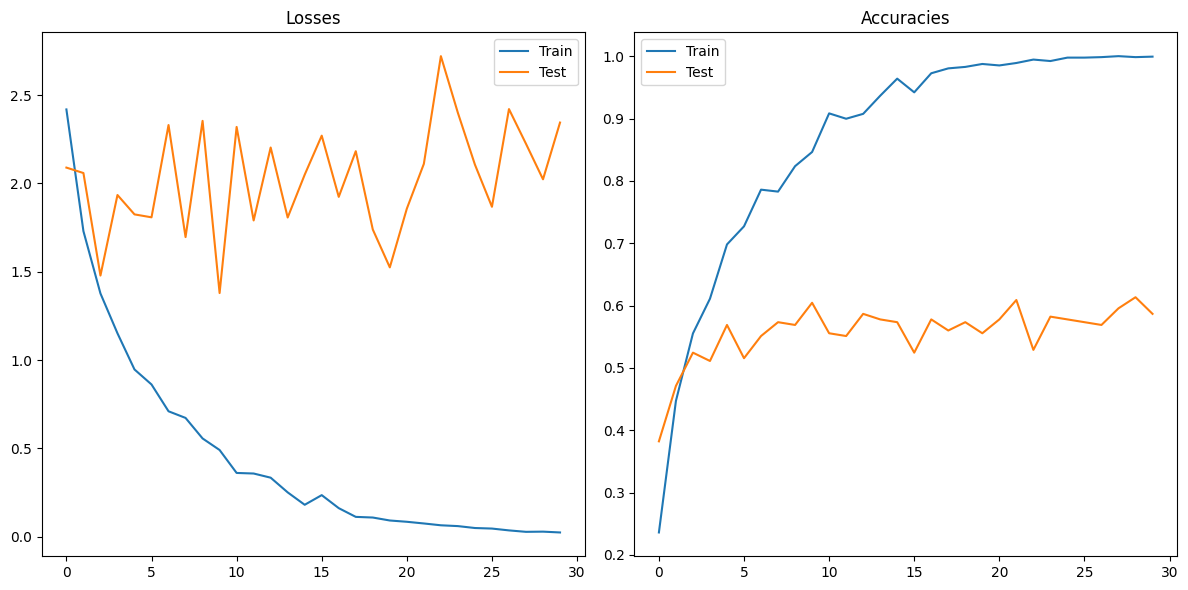

In [16]:
plot_statistics(statistics)

Test Loss: 1.7764418486585007
Test Accuracy: 0.566499162479062


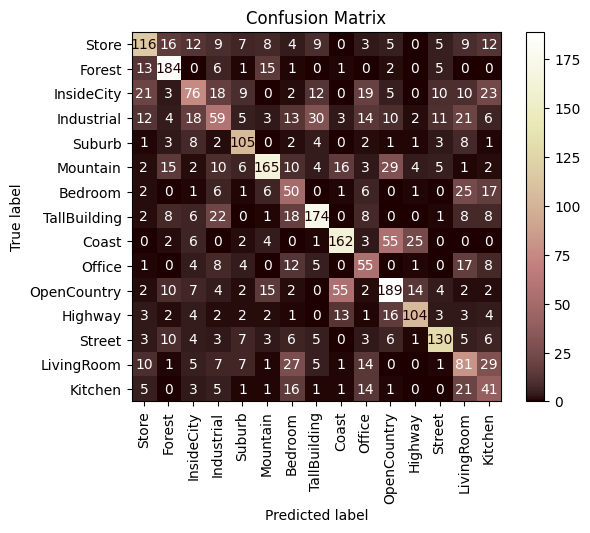

In [17]:
test_model(model, test_loader, criterion)

## Batch Normalization + Adam + Dropout
Kernel Size = 3


In [6]:
model = Model(kernel_size=3, normalization=True, dropout=True)
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters())

In [7]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 39%|▍| 39/100 [00:59<01:33,  1.53s/it, Train Loss=0.675, Test Loss=2.47, Train Acc=0.769, T

Stopped early, epoch: 39


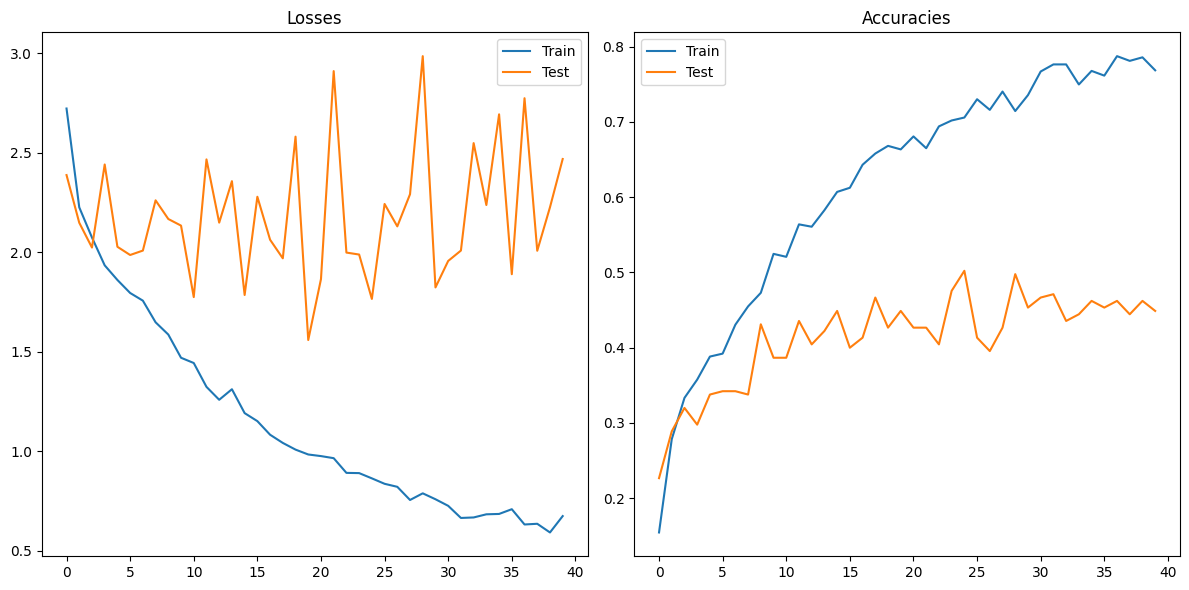

In [8]:
plot_statistics(statistics)

Test Loss: 1.8541503612031327
Test Accuracy: 0.4934673366834171


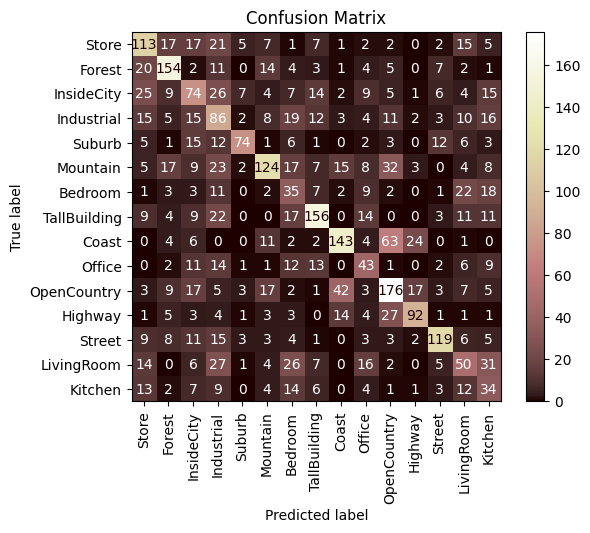

In [9]:
test_model(model, test_loader, criterion)

## Batch Normalization + Adam + Ensemble
Kernel Size = 3


In [10]:
models = []

for _ in range(10):
    model = Model(kernel_size=3, normalization=True)
    model.net.apply(init_weights)

    models.append(model)

criterion = th.nn.CrossEntropyLoss()

In [11]:
statistics = []
for i, model in enumerate(models):
    print(f"Model {i}")
    optimizer = th.optim.Adam(model.parameters())
        
    statistic = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)
    statistics.append(statistic)

 34%|▎| 34/100 [00:49<01:35,  1.45s/it, Train Loss=0.0207, Test Loss=2.24, Train Acc=1, Test


Stopped early, epoch: 34


 28%|▎| 28/100 [00:40<01:45,  1.46s/it, Train Loss=0.0256, Test Loss=2.65, Train Acc=1, Test


Stopped early, epoch: 28


 28%|▎| 28/100 [00:41<01:45,  1.47s/it, Train Loss=0.044, Test Loss=2.27, Train Acc=0.996, T


Stopped early, epoch: 28


 29%|▎| 29/100 [00:43<01:45,  1.49s/it, Train Loss=0.0316, Test Loss=3.11, Train Acc=0.998, 


Stopped early, epoch: 29


 28%|▎| 28/100 [00:41<01:45,  1.47s/it, Train Loss=0.0398, Test Loss=1.77, Train Acc=0.998, 


Stopped early, epoch: 28


 30%|▎| 30/100 [00:42<01:40,  1.43s/it, Train Loss=0.0246, Test Loss=2.63, Train Acc=0.998, 


Stopped early, epoch: 30


 30%|▎| 30/100 [00:45<01:47,  1.53s/it, Train Loss=0.0239, Test Loss=2.04, Train Acc=0.999, 


Stopped early, epoch: 30


 26%|▎| 26/100 [00:37<01:45,  1.43s/it, Train Loss=0.0297, Test Loss=1.71, Train Acc=0.998, 


Stopped early, epoch: 26


 26%|▎| 26/100 [00:35<01:41,  1.38s/it, Train Loss=0.0292, Test Loss=1.93, Train Acc=1, Test


Stopped early, epoch: 26


 29%|▎| 29/100 [00:39<01:37,  1.37s/it, Train Loss=0.0296, Test Loss=1.99, Train Acc=0.998, 

Stopped early, epoch: 29


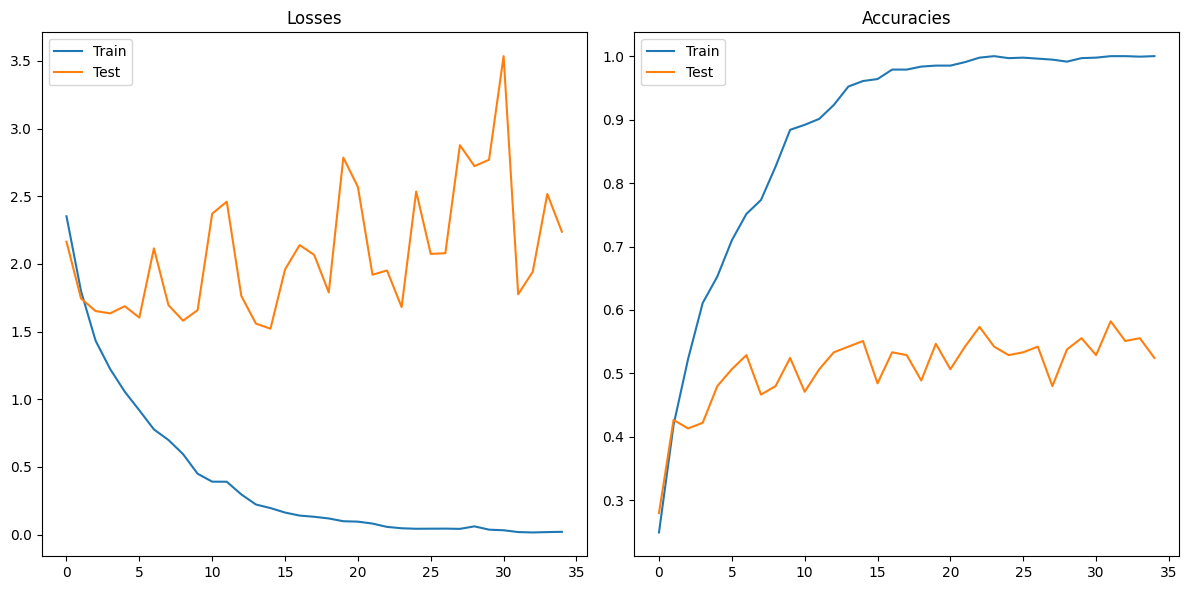

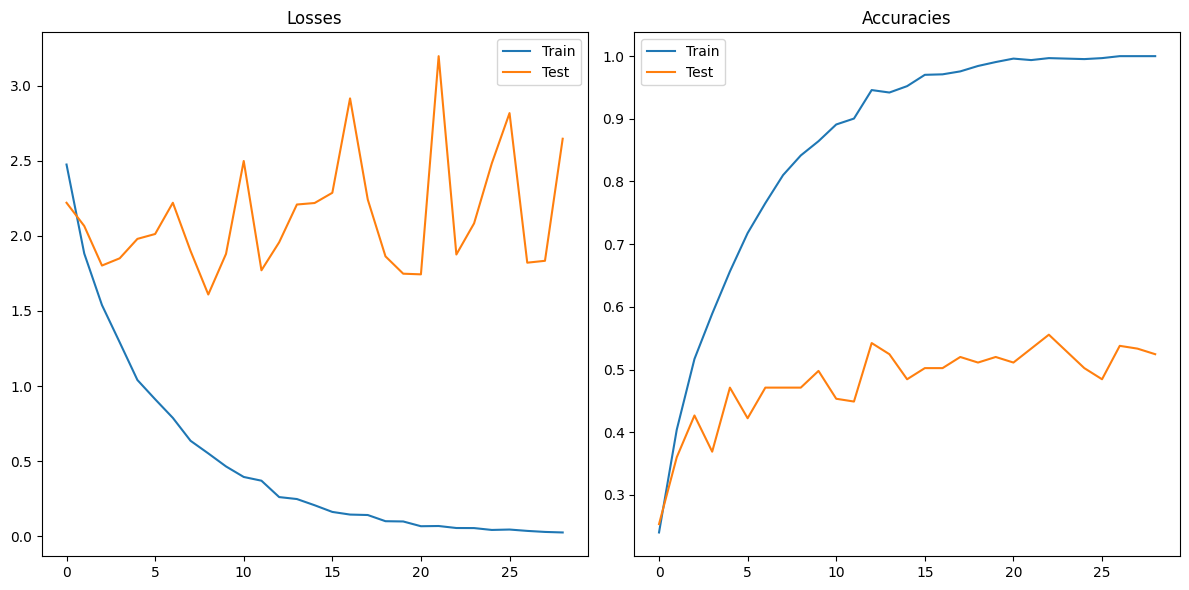

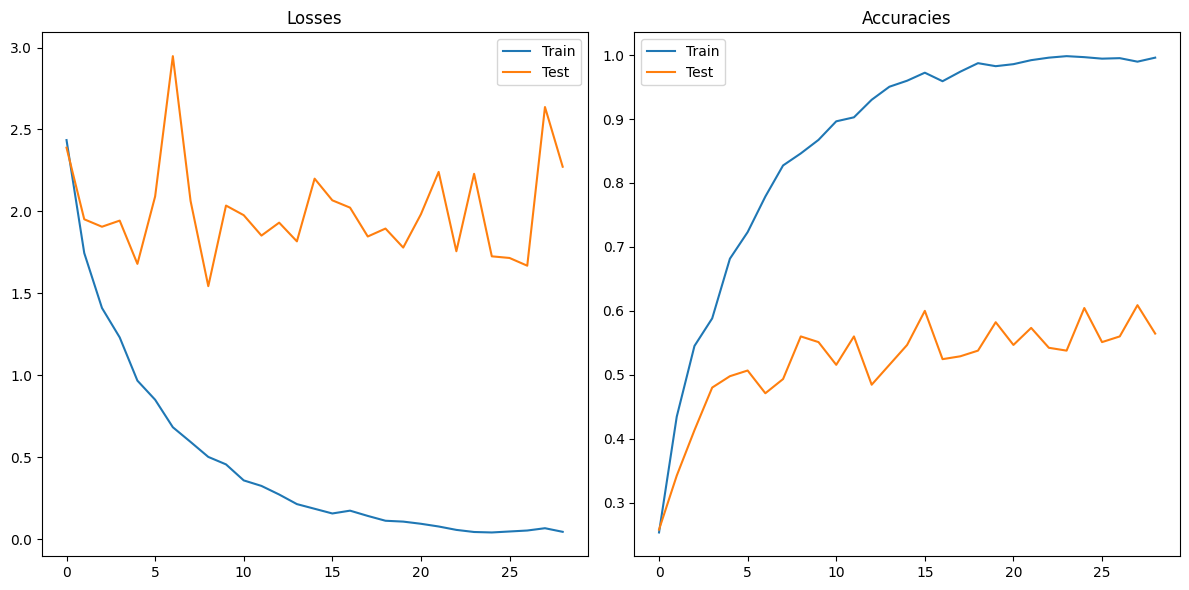

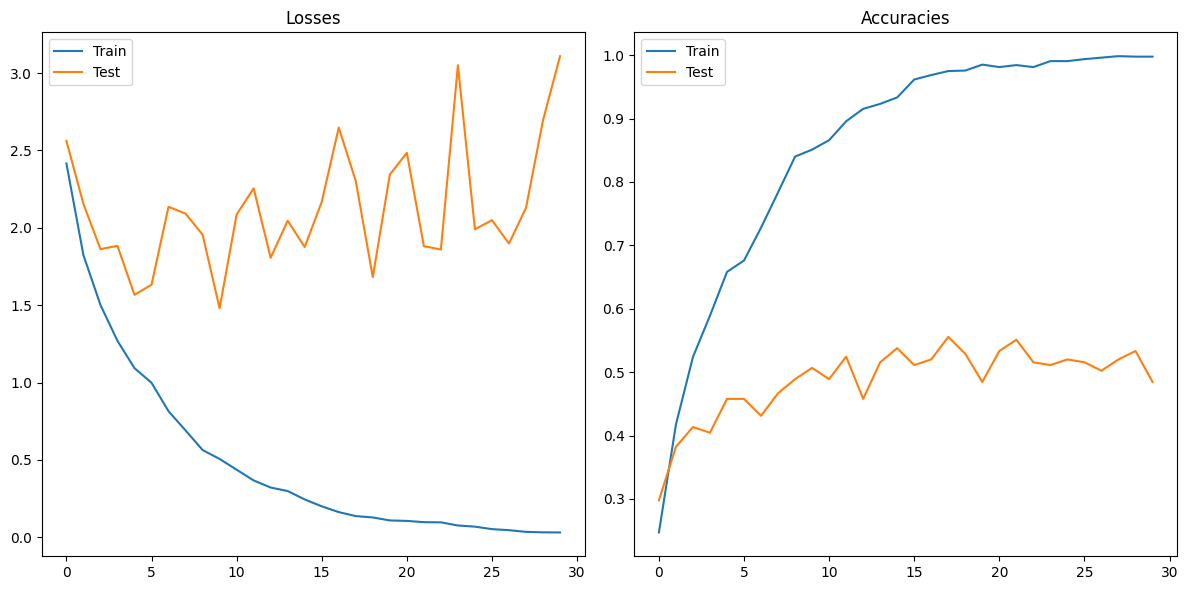

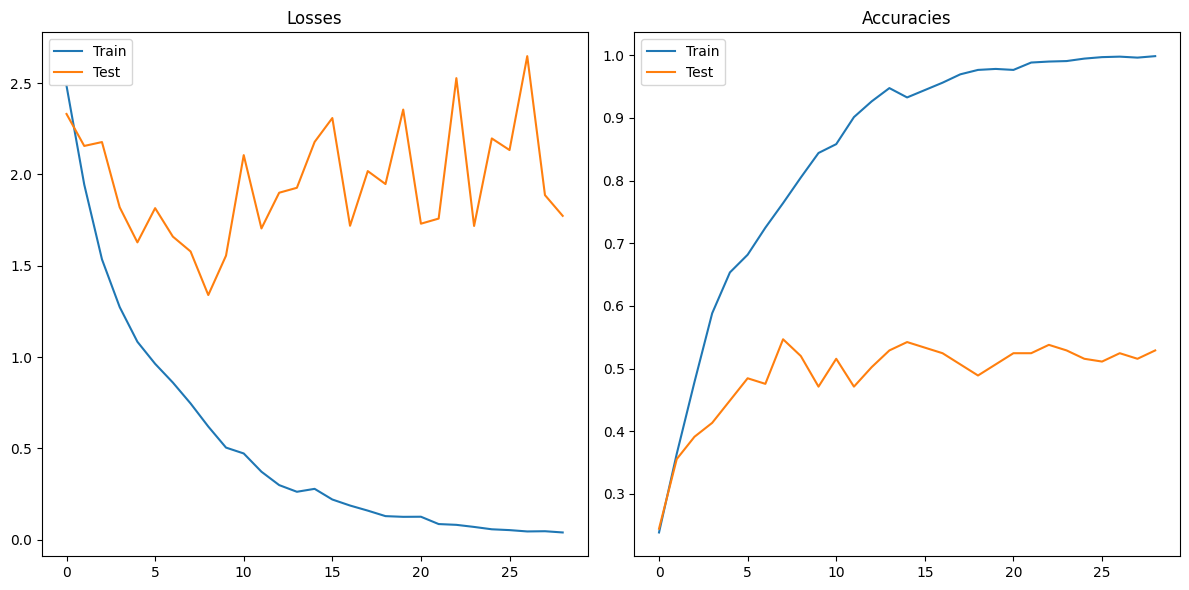

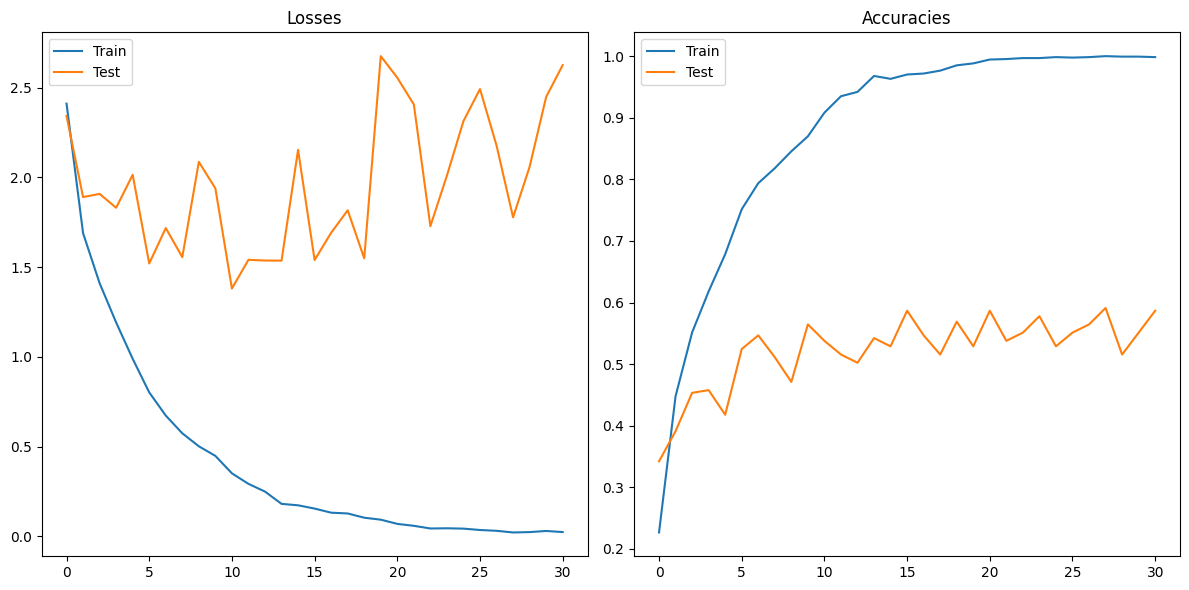

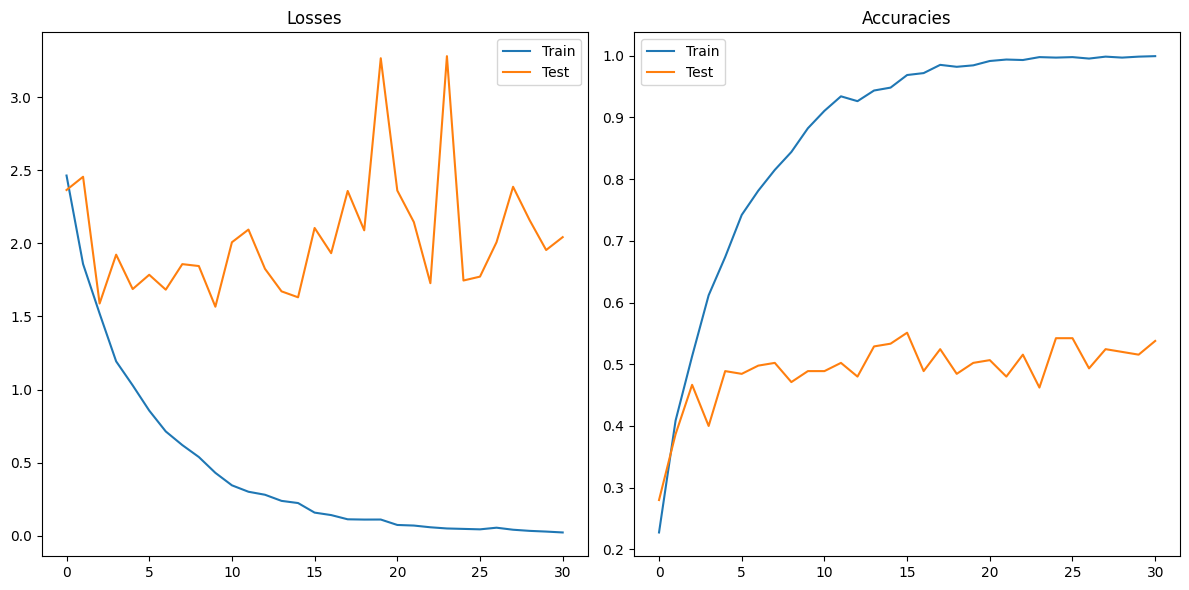

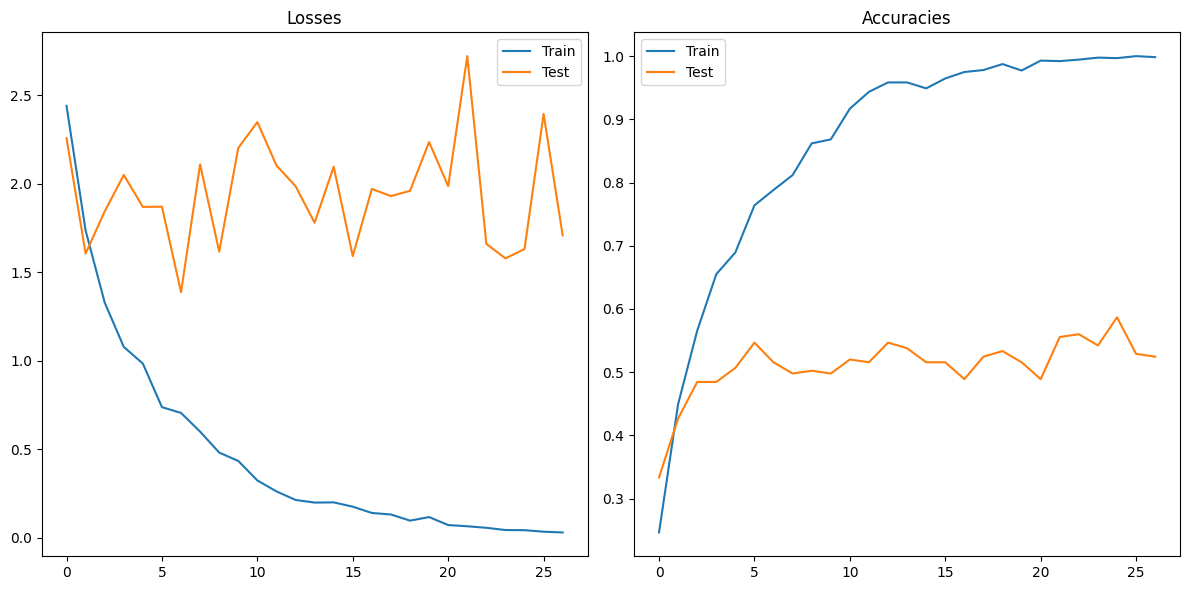

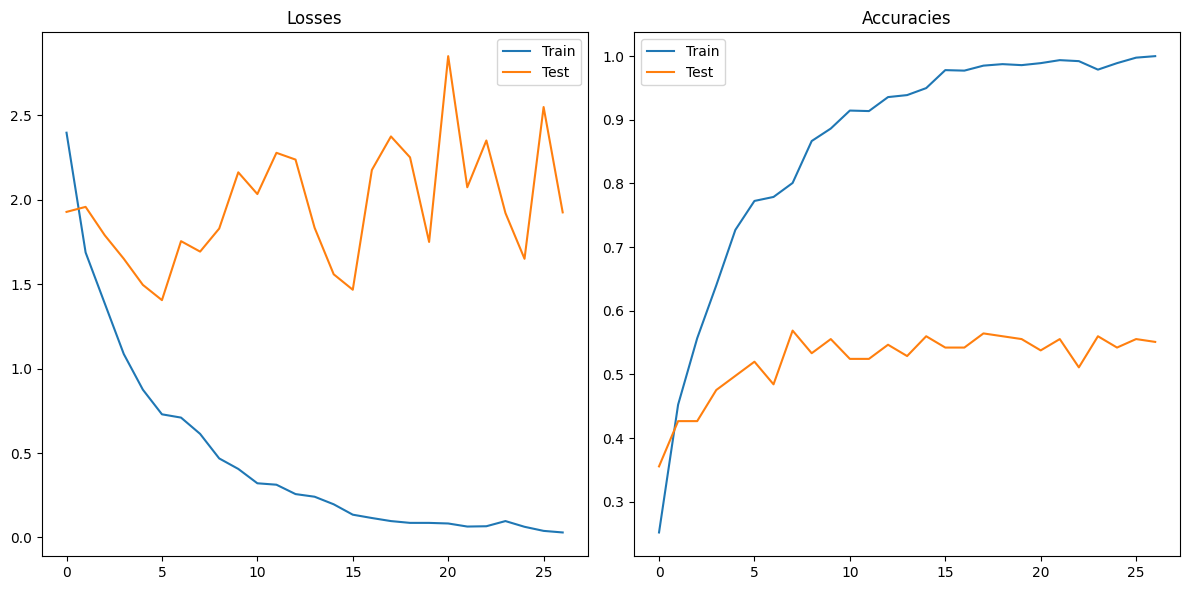

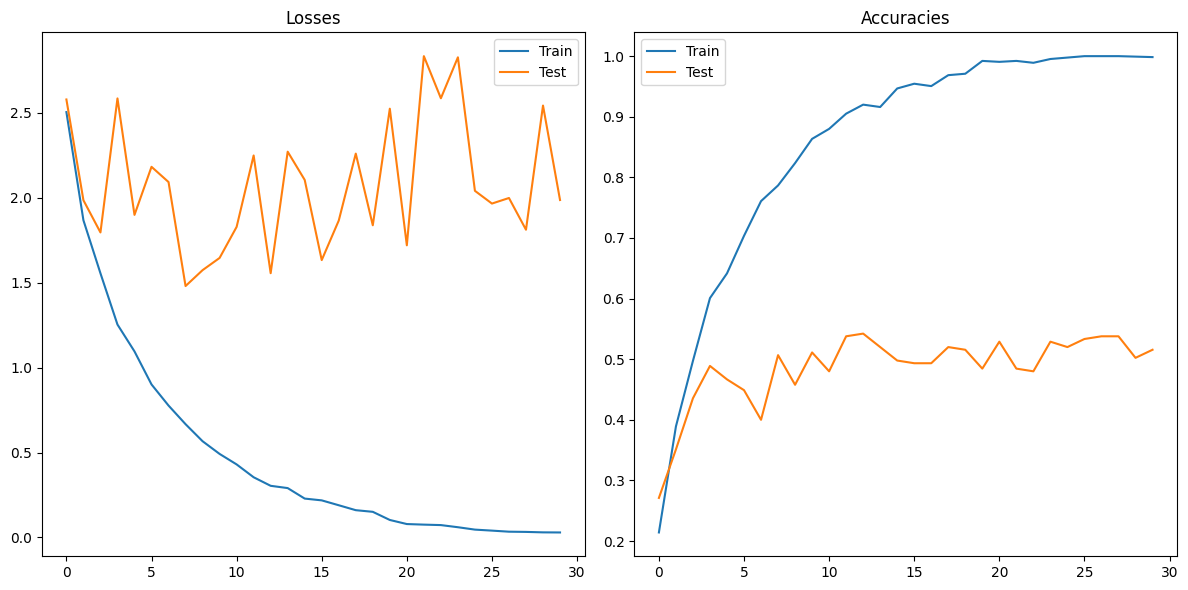

In [12]:
for statistic in statistics:
    plot_statistics(statistic)

Test Loss: 5.322610855102539
Test Accuracy: 0.21876047551631927


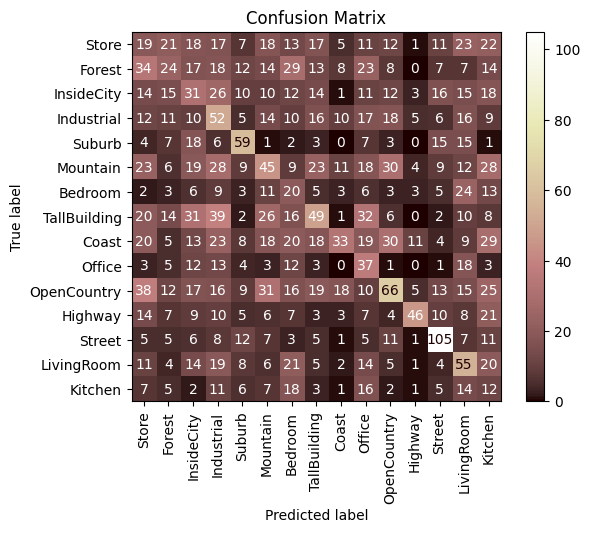

In [13]:
test_model(model, test_loader, criterion)

# Exercise 3

In [15]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
model = torchvision.models.alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.features[0] = th.nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
model.classifier[6] = th.nn.Linear(4096, 15, bias=True)
for param in model.classifier.parameters():
    param.requires_grad = True

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.classifier.parameters())

NameError: name 'torchvision' is not defined

In [12]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

  0%|                                                               | 0/100 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 11, 11], expected input[32, 1, 64, 64] to have 3 channels, but got 1 channels instead

In [ ]:
plot_statistics(statistics)

In [ ]:
test_model(model, test_loader, criterion)

# Exercise 4

# Exercise 5

# Exercise 6

# Exercise 7